In [1]:
import torchaudio
import numpy as np
train_dataset = torchaudio.datasets.VoxCeleb1Identification('/mnt/d/VoxCeleb1Identification/data', subset='train', download=False)
test_dataset = torchaudio.datasets.VoxCeleb1Identification('/mnt/d/VoxCeleb1Identification/data', subset='test', download=False)

In [2]:


# present_train_audio_files = []
# missing_train_audio_files = []
# sub_train_len = len(train_dataset) #4000
# for i in range(sub_train_len):
#   try:
#     train_dataset[i][2]
#     present_train_audio_files.append(i)
#   except:
#     missing_train_audio_files.append(i)

# present_test_audio_files = []
# missing_test_audio_files = []
# sub_test_len = len(test_dataset) #200
# for i in range(sub_test_len):
#   try:
#     test_dataset[i][2]
#     present_test_audio_files.append(i)
#   except:
#     missing_test_audio_files.append(i) 

In [3]:
import json
# json.dump(present_train_audio_files, open("present_train_audio_files.json", 'w'))
# json.dump(present_test_audio_files, open("present_test_audio_files.json", 'w'))
present_train_audio_files = json.load(open("present_train_audio_files.json", 'r'))
present_test_audio_files = json.load(open("present_test_audio_files.json", 'r'))

There are 4361 missing files in train dataset and 279 missing files in test dataset. Lets remove those samples.

In [56]:
from torch.utils.data import Subset
from torch.utils.data import Dataset
import torch

class VoxCeleb1IdentificationUnified(Dataset):
    
    def __init__(self, voxceleb1_dataset, present_audio_files = []):
        self.voxceleb1_dataset = voxceleb1_dataset
        self.voxceleb1_dataset = Subset(self.voxceleb1_dataset, present_audio_files)
        
        self.num_samples_per_clip = 80000   
        self.mel_spectrogram_transformation = torchaudio.transforms.MelSpectrogram(
            sample_rate=16000,
            n_fft=1024,
            hop_length=512,
            n_mels=64)

    def __getitem__(self, idx):
        waveform, _, target, _ = self.voxceleb1_dataset[idx]
        waveform = self._right_zero_pad(self._cut_if_necessary(waveform))
        mel_spec = self.mel_spectrogram_transformation(waveform)
        return mel_spec, target
    
    def __len__(self):
        return len(self.voxceleb1_dataset)
    
    def _right_zero_pad(self, signal):
      length_signal = signal.shape[1]
      if length_signal < self.num_samples_per_clip:
          num_missing_samples = self.num_samples_per_clip - length_signal
          signal = torch.nn.functional.pad(signal, (0, num_missing_samples))
      return signal
    
    def _cut_if_necessary(self, signal):
      if signal.shape[1] > self.num_samples_per_clip:
          signal = signal[:, :self.num_samples_per_clip]
      return signal
  
train_subset = VoxCeleb1IdentificationUnified(train_dataset, present_train_audio_files[:1000])
test_subset = VoxCeleb1IdentificationUnified(train_dataset, present_test_audio_files[:100])

In [57]:
idx = np.random.randint(0, 100)
print(idx)
print(f'train: {train_subset[idx]}')
print(f'test: {test_subset[idx]}')

64
train: (tensor([[[1.0737e-01, 8.7193e-02, 6.1479e-02,  ..., 1.8503e-01,
          1.4456e-01, 3.5238e-02],
         [5.4992e-01, 1.6451e-01, 1.3106e-01,  ..., 5.4078e-01,
          2.3890e-01, 5.4040e-01],
         [2.5667e-01, 2.8298e-01, 3.1582e-01,  ..., 4.0690e+00,
          9.1684e+00, 1.8490e+01],
         ...,
         [3.7681e-04, 5.0650e-04, 2.5355e-04,  ..., 7.7599e-05,
          8.8723e-05, 1.3732e-03],
         [2.1649e-04, 3.3762e-04, 6.4488e-04,  ..., 4.0599e-05,
          6.3677e-05, 1.5194e-03],
         [1.2252e-04, 3.5836e-04, 5.4459e-04,  ..., 9.7730e-05,
          6.1318e-05, 9.3805e-04]]]), 2)
test: (tensor([[[1.0737e-01, 8.7193e-02, 6.1479e-02,  ..., 1.8503e-01,
          1.4456e-01, 3.5238e-02],
         [5.4992e-01, 1.6451e-01, 1.3106e-01,  ..., 5.4078e-01,
          2.3890e-01, 5.4040e-01],
         [2.5667e-01, 2.8298e-01, 3.1582e-01,  ..., 4.0690e+00,
          9.1684e+00, 1.8490e+01],
         ...,
         [3.7681e-04, 5.0650e-04, 2.5355e-04,  ..., 7.759

In [21]:
print(f'Length of train dataset: {len(train_subset)}')
print(train_subset[0])
print(' ')
print(f'Length of test dataset: {len(test_subset)}')
print(test_subset[0])
speakers_test = []
speakers_train = []
# 1754
for i in range(len(test_subset)):
  speakers_test.append(test_subset[i][1])
print(' ')
print(f'There are {len(set(speakers_test))} unique speakers in first {len(test_subset)} samples of test set')

for i in range(len(train_subset)):
  speakers_train.append(train_subset[i][1])
print(' ')
print(f'There are {len(set(speakers_train))} unique speakers in first {len(train_subset)} samples of train set')

Length of train dataset: 134000
(tensor([[ 0.0703,  0.0703,  0.0916,  ..., -0.0863, -0.1171, -0.1537]]), 16000, 1, 'id10001-1zcIwhmdeo4-00001')
 
Length of test dataset: 7972
(tensor([[-0.0556, -0.0882, -0.1060,  ...,  0.0062,  0.0054,  0.0036]]), 16000, 1, 'id10001-Y8hIVOBuels-00001')
 
There are 1211 unique speakers in first 7972 samples of test set
 
There are 1211 unique speakers in first 134000 samples of train set


In [22]:
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

test_speakers_classes = [str(i) for i in range(len(set(speakers_test)))]

In [31]:
[test_subset[i][1] for i in range(10)]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

# Prepare dataset classes

In [23]:
import numpy as np
from PIL import Image

from torch.utils.data.sampler import BatchSampler


class TripletVoxCeleb1ID(Dataset):
    """
    Train: For each sample (anchor) randomly chooses a positive and negative samples
    Test: Creates fixed triplets for testing
    """

    def __init__(self, voxceleb1_dataset, train=True):
        self.voxceleb1_dataset = voxceleb1_dataset
        self.train = train
        self.mel_spectrogram_transformation = torchaudio.transforms.MelSpectrogram(
            sample_rate=16000,
            n_fft=1024,
            hop_length=512,
            n_mels=64)
        self.num_samples_per_clip = 80000 # 5 sec

        if self.train:
            self.train_labels = torch.tensor([self.voxceleb1_dataset[i][2]
                                              for i in range(len(self.voxceleb1_dataset))])
            
            self.labels_set = set(self.train_labels.numpy())
            self.label_to_indices = {label: np.where(self.train_labels.numpy() == label)[0]
                                     for label in self.labels_set}

        else:
            self.test_labels = torch.tensor([self.voxceleb1_dataset[i][2] 
                                              for i in range(len(self.voxceleb1_dataset))])
        
            # generate fixed triplets for testing
            self.labels_set = set(self.test_labels.numpy())
            self.label_to_indices = {label: np.where(self.test_labels.numpy() == label)[0]
                                     for label in self.labels_set}

            random_state = np.random.RandomState(29)

            triplets = [[i,
                         random_state.choice(self.label_to_indices[self.test_labels[i].item()]),
                         random_state.choice(self.label_to_indices[
                                                 np.random.choice(
                                                     list(self.labels_set - set([self.test_labels[i].item()]))
                                                 )
                                             ])
                         ]
                        for i in range(len(self.test_labels))]
            self.test_triplets = triplets

    def __getitem__(self, index):
        if self.train:
            audio1, label1 = self._right_zero_pad(self._cut_if_necessary(self.voxceleb1_dataset[index][0])), self.train_labels[index].item()
            positive_index = index
            while positive_index == index:
                positive_index = np.random.choice(self.label_to_indices[label1])
                #! 99% that for one particular speaker there is just 1 recording 
                #TODO Create histogram of number of samples assigned to one speaker
            negative_label = np.random.choice(list(self.labels_set - set([label1])))
            negative_index = np.random.choice(self.label_to_indices[negative_label])
            audio2 = self._right_zero_pad(self._cut_if_necessary(self.voxceleb1_dataset[positive_index][0]))
            audio3 = self._right_zero_pad(self._cut_if_necessary(self.voxceleb1_dataset[negative_index][0]))
        else:
            audio1 = self._right_zero_pad(self._cut_if_necessary(self.voxceleb1_dataset[self.test_triplets[index][0]][0]))
            audio2 = self._right_zero_pad(self._cut_if_necessary(self.voxceleb1_dataset[self.test_triplets[index][1]][0]))
            audio3 = self._right_zero_pad(self._cut_if_necessary(self.voxceleb1_dataset[self.test_triplets[index][2]][0]))
                                          
        spec1 = self.mel_spectrogram_transformation(audio1)
        spec2 = self.mel_spectrogram_transformation(audio2)
        spec3 = self.mel_spectrogram_transformation(audio3)     

        return (spec1, spec2, spec3), []
    
    def _right_zero_pad(self, signal):
      length_signal = signal.shape[1]
      if length_signal < self.num_samples_per_clip:
          num_missing_samples = self.num_samples_per_clip - length_signal
          signal = torch.nn.functional.pad(signal, (0, num_missing_samples))
      return signal
    
    def _cut_if_necessary(self, signal):
      if signal.shape[1] > self.num_samples_per_clip:
          signal = signal[:, :self.num_samples_per_clip]
      return signal

    def __len__(self):
        return len(self.voxceleb1_dataset)

In [24]:
triplet_dataset = TripletVoxCeleb1ID(train_subset, train=True)
print(triplet_dataset.label_to_indices)
triplet_dataset = TripletVoxCeleb1ID(test_subset, train=False)
print(triplet_dataset.label_to_indices)

KeyboardInterrupt: 

In [14]:
triplet_dataset[0][0][0].shape

torch.Size([1, 64, 157])

# Neural Networks

In [15]:
import torch.nn as nn
import torch.nn.functional as F


class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        self.convnet = nn.Sequential(nn.Conv2d(1, 32, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2),
                                     nn.Conv2d(32, 64, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2),
                                     nn.Conv2d(64, 128, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2))

        self.fc = nn.Sequential(nn.Linear(8192, 128), # 6*4*4x256
                                nn.PReLU(),
                                nn.Linear(128, 256),
                                nn.PReLU(),
                                nn.Linear(256, 128)
                                )

    def forward(self, x):
        output = self.convnet(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

    def get_embedding(self, x):
        return self.forward(x)

class EmbeddingNetL2(EmbeddingNet):
    def __init__(self):
        super(EmbeddingNetL2, self).__init__()

    def forward(self, x):
        output = super(EmbeddingNetL2, self).forward(x)
        output /= output.pow(2).sum(1, keepdim=True).sqrt()
        return output

    def get_embedding(self, x):
        return self.forward(x)
        
class SiameseNet(nn.Module):
    def __init__(self, embedding_net):
        super(SiameseNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        return output1, output2

    def get_embedding(self, x):
        return self.embedding_net(x)


class TripletNet(nn.Module):
    def __init__(self, embedding_net):
        super(TripletNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2, x3):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        output3 = self.embedding_net(x3)
        return output1, output2, output3

    def get_embedding(self, x):
        return self.embedding_net(x)

In [16]:
from torchsummary import summary
model = EmbeddingNet()
summary(model, (1, 64, 157))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 60, 153]             832
             PReLU-2          [-1, 32, 60, 153]               1
         MaxPool2d-3           [-1, 32, 30, 76]               0
            Conv2d-4           [-1, 64, 26, 72]          51,264
             PReLU-5           [-1, 64, 26, 72]               1
         MaxPool2d-6           [-1, 64, 13, 36]               0
            Conv2d-7           [-1, 128, 9, 32]         204,928
             PReLU-8           [-1, 128, 9, 32]               1
         MaxPool2d-9           [-1, 128, 4, 16]               0
           Linear-10                  [-1, 128]       1,048,704
            PReLU-11                  [-1, 128]               1
           Linear-12                  [-1, 256]          33,024
            PReLU-13                  [-1, 256]               1
           Linear-14                   

# Training

In [17]:
import torch
import numpy as np
from tqdm import tqdm


def fit(train_loader, val_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[],
        start_epoch=0):
    """
    Loaders, model, loss function and metrics should work together for a given task,
    i.e. The model should be able to process data output of loaders,
    loss function should process target output of loaders and outputs from the model

    Examples: Classification: batch loader, classification model, NLL loss, accuracy metric
    Siamese network: Siamese loader, siamese model, contrastive loss
    Online triplet learning: batch loader, embedding model, online triplet loss
    """
    for epoch in range(0, start_epoch):
        scheduler.step()

    for epoch in range(start_epoch, n_epochs):
        scheduler.step()
        pbar = tqdm(total=1)
        # Train stage
        train_loss, metrics = train_epoch(train_loader, model, loss_fn, optimizer, cuda, log_interval, metrics)

        message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}'.format(epoch + 1, n_epochs, train_loss)
        for metric in metrics:
            message += '\t{}: {}'.format(metric.name(), metric.value())

        val_loss, metrics = test_epoch(val_loader, model, loss_fn, cuda, metrics)
        val_loss /= len(val_loader)

        message += '\nEpoch: {}/{}. Validation set: Average loss: {:.4f}'.format(epoch + 1, n_epochs,
                                                                                 val_loss)
        for metric in metrics:
            message += '\t{}: {}'.format(metric.name(), metric.value())
        
        # update progress bar
        pbar.update(1)
        pbar.set_description(f"Epoch {epoch+1}/{n_epochs} train_loss={train_loss:.2f} val_loss={val_loss:.2f}")
        pbar.close()

        # print(message)


def train_epoch(train_loader, model, loss_fn, optimizer, cuda, log_interval, metrics):
    for metric in metrics:
        metric.reset()

    model.train()
    losses = []
    total_loss = 0

    batch_idx = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        target = target if len(target) > 0 else None
        if not type(data) in (tuple, list):
            data = (data,)
        if cuda:
            data = tuple(d.cuda() for d in data)
            if target is not None:
                target = target.cuda()


        optimizer.zero_grad()
        outputs = model(*data)

        if type(outputs) not in (tuple, list):
            outputs = (outputs,)

        loss_inputs = outputs
        if target is not None:
            target = (target,)
            loss_inputs += target

        loss_outputs = loss_fn(*loss_inputs)
        loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
        losses.append(loss.item())
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        for metric in metrics:
            metric(outputs, target, loss_outputs)

        if batch_idx % log_interval == 0:
            message = 'Train: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                batch_idx * len(data[0]), len(train_loader.dataset), # type: ignore
                #! if batch size is smaller than defined then it may become smaller.
                100. * batch_idx / len(train_loader), np.mean(losses))
            for metric in metrics:
                message += '\t{}: {}'.format(metric.name(), metric.value())

            print(message)
            losses = []

    total_loss /= (batch_idx + 1)
    return total_loss, metrics


def test_epoch(val_loader, model, loss_fn, cuda, metrics):
    with torch.no_grad():
        for metric in metrics:
            metric.reset()
        model.eval()
        val_loss = 0
        for batch_idx, (data, target) in enumerate(val_loader):
            target = target if len(target) > 0 else None
            if not type(data) in (tuple, list):
                data = (data,)
            if cuda:
                data = tuple(d.cuda() for d in data)
                if target is not None:
                    target = target.cuda()

            outputs = model(*data)

            if type(outputs) not in (tuple, list):
                outputs = (outputs,)
            loss_inputs = outputs
            if target is not None:
                target = (target,)
                loss_inputs += target

            loss_outputs = loss_fn(*loss_inputs)
            loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
            val_loss += loss.item()

            for metric in metrics:
                metric(outputs, target, loss_outputs)

    return val_loss, metrics

# Loss functions

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ContrastiveLoss(nn.Module):
    """
    Contrastive loss
    Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """

    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, output1, output2, target, size_average=True):
        distances = (output2 - output1).pow(2).sum(1)  # squared distances
        losses = 0.5 * (target.float() * distances +
                        (1 + -1 * target).float() * F.relu(self.margin - (distances + self.eps).sqrt()).pow(2))
        return losses.mean() if size_average else losses.sum()


class TripletLoss(nn.Module):
    """
    Triplet loss
    Takes embeddings of an anchor sample, a positive sample and a negative sample
    """

    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = (anchor - positive).pow(2).sum(1)  # .pow(.5)
        distance_negative = (anchor - negative).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()

# Main

In [19]:
triplet_train_dataset = TripletVoxCeleb1ID(train_subset) # Returns triplets of images
triplet_test_dataset = TripletVoxCeleb1ID(test_subset)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, **kwargs) # type: ignore
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, drop_last=True, **kwargs) # type: ignore

# Set up the network and training parameters
margin = 1.
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 1
log_interval = 1

# train_epoch(triplet_train_loader, model, loss_fn, optimizer, cuda, log_interval, metrics=[])
fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

/home/armak/anaconda3/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
  0%|          | 0/1 [00:00<?, ?it/s]

Train: [0/134000 (0%)]	Loss: 46.505810
Train: [128/134000 (0%)]	Loss: 6607.042480
Train: [256/134000 (0%)]	Loss: 323.967682
Train: [384/134000 (0%)]	Loss: 19.830435
Train: [512/134000 (0%)]	Loss: 43.465996
Train: [640/134000 (0%)]	Loss: 151.952377
Train: [768/134000 (1%)]	Loss: 512.225342
Train: [896/134000 (1%)]	Loss: 7719.829102
Train: [1024/134000 (1%)]	Loss: 3035.507812
Train: [1152/134000 (1%)]	Loss: 359.456512
Train: [1280/134000 (1%)]	Loss: 1446.500244
Train: [1408/134000 (1%)]	Loss: 1371.671631
Train: [1536/134000 (1%)]	Loss: 4508.273926
Train: [1664/134000 (1%)]	Loss: 135.261536
Train: [1792/134000 (1%)]	Loss: 14.583118
Train: [1920/134000 (1%)]	Loss: 61.244160
Train: [2048/134000 (2%)]	Loss: 193.183472
Train: [2176/134000 (2%)]	Loss: 877.877502
Train: [2304/134000 (2%)]	Loss: 1134.127686
Train: [2432/134000 (2%)]	Loss: 799.294312
Train: [2560/134000 (2%)]	Loss: 1561.016602
Train: [2688/134000 (2%)]	Loss: 250.728729
Train: [2816/134000 (2%)]	Loss: 5734.065918
Train: [2944/1340

  0%|          | 0/1 [00:00<?, ?it/s]

Train: [0/134000 (0%)]	Loss: 1.002808
Train: [128/134000 (0%)]	Loss: 2.233634
Train: [256/134000 (0%)]	Loss: 1.060297
Train: [384/134000 (0%)]	Loss: 1.041296
Train: [512/134000 (0%)]	Loss: 0.947175
Train: [640/134000 (0%)]	Loss: 3.164761
Train: [768/134000 (1%)]	Loss: 2.149680
Train: [896/134000 (1%)]	Loss: 1.413778
Train: [1024/134000 (1%)]	Loss: 0.888028
Train: [1152/134000 (1%)]	Loss: 1.125327
Train: [1280/134000 (1%)]	Loss: 1.345574
Train: [1408/134000 (1%)]	Loss: 1.027205
Train: [1536/134000 (1%)]	Loss: 1.950952
Train: [1664/134000 (1%)]	Loss: 1.003796
Train: [1792/134000 (1%)]	Loss: 1.456486
Train: [1920/134000 (1%)]	Loss: 0.954161
Train: [2048/134000 (2%)]	Loss: 1.080229
Train: [2176/134000 (2%)]	Loss: 1.084535
Train: [2304/134000 (2%)]	Loss: 1.122078
Train: [2432/134000 (2%)]	Loss: 1.046358
Train: [2560/134000 (2%)]	Loss: 0.912019
Train: [2688/134000 (2%)]	Loss: 0.940625
Train: [2816/134000 (2%)]	Loss: 1.314721
Train: [2944/134000 (2%)]	Loss: 1.084351
Train: [3072/134000 (2%)]	

  0%|          | 0/1 [00:00<?, ?it/s]

Train: [0/134000 (0%)]	Loss: 1.047204
Train: [128/134000 (0%)]	Loss: 0.921951
Train: [256/134000 (0%)]	Loss: 1.077706
Train: [384/134000 (0%)]	Loss: 1.093858
Train: [512/134000 (0%)]	Loss: 1.020971
Train: [640/134000 (0%)]	Loss: 0.936115
Train: [768/134000 (1%)]	Loss: 1.125630
Train: [896/134000 (1%)]	Loss: 0.969793
Train: [1024/134000 (1%)]	Loss: 0.934636
Train: [1152/134000 (1%)]	Loss: 1.533544
Train: [1280/134000 (1%)]	Loss: 1.235154
Train: [1408/134000 (1%)]	Loss: 1.378726
Train: [1536/134000 (1%)]	Loss: 0.961929
Train: [1664/134000 (1%)]	Loss: 0.962809
Train: [1792/134000 (1%)]	Loss: 1.204489
Train: [1920/134000 (1%)]	Loss: 1.074122
Train: [2048/134000 (2%)]	Loss: 1.070882
Train: [2176/134000 (2%)]	Loss: 1.068933
Train: [2304/134000 (2%)]	Loss: 1.175206
Train: [2432/134000 (2%)]	Loss: 1.169233
Train: [2560/134000 (2%)]	Loss: 1.028660
Train: [2688/134000 (2%)]	Loss: 1.010433
Train: [2816/134000 (2%)]	Loss: 0.957176
Train: [2944/134000 (2%)]	Loss: 1.359382
Train: [3072/134000 (2%)]	

  0%|          | 0/1 [00:00<?, ?it/s]

Train: [0/134000 (0%)]	Loss: 0.929872
Train: [128/134000 (0%)]	Loss: 0.997911
Train: [256/134000 (0%)]	Loss: 0.879420
Train: [384/134000 (0%)]	Loss: 1.234148
Train: [512/134000 (0%)]	Loss: 0.906077
Train: [640/134000 (0%)]	Loss: 0.970054
Train: [768/134000 (1%)]	Loss: 0.974627
Train: [896/134000 (1%)]	Loss: 1.011878
Train: [1024/134000 (1%)]	Loss: 1.056636
Train: [1152/134000 (1%)]	Loss: 0.987284
Train: [1280/134000 (1%)]	Loss: 0.988729
Train: [1408/134000 (1%)]	Loss: 0.998239
Train: [1536/134000 (1%)]	Loss: 1.557172
Train: [1664/134000 (1%)]	Loss: 0.829849
Train: [1792/134000 (1%)]	Loss: 0.904010
Train: [1920/134000 (1%)]	Loss: 1.049930
Train: [2048/134000 (2%)]	Loss: 1.018764
Train: [2176/134000 (2%)]	Loss: 0.959991
Train: [2304/134000 (2%)]	Loss: 0.984053
Train: [2432/134000 (2%)]	Loss: 0.912564
Train: [2560/134000 (2%)]	Loss: 0.882725
Train: [2688/134000 (2%)]	Loss: 0.941312
Train: [2816/134000 (2%)]	Loss: 0.842684
Train: [2944/134000 (2%)]	Loss: 1.083770
Train: [3072/134000 (2%)]	

  0%|          | 0/1 [00:00<?, ?it/s]

Train: [0/134000 (0%)]	Loss: 0.909891
Train: [128/134000 (0%)]	Loss: 0.783108
Train: [256/134000 (0%)]	Loss: 0.850662
Train: [384/134000 (0%)]	Loss: 0.682682
Train: [512/134000 (0%)]	Loss: 0.705480
Train: [640/134000 (0%)]	Loss: 0.816923
Train: [768/134000 (1%)]	Loss: 0.782019
Train: [896/134000 (1%)]	Loss: 0.868926
Train: [1024/134000 (1%)]	Loss: 0.823198
Train: [1152/134000 (1%)]	Loss: 0.841666
Train: [1280/134000 (1%)]	Loss: 0.731333
Train: [1408/134000 (1%)]	Loss: 0.874510
Train: [1536/134000 (1%)]	Loss: 0.708718
Train: [1664/134000 (1%)]	Loss: 0.709327
Train: [1792/134000 (1%)]	Loss: 0.713352
Train: [1920/134000 (1%)]	Loss: 0.692104
Train: [2048/134000 (2%)]	Loss: 0.725870
Train: [2176/134000 (2%)]	Loss: 0.954204
Train: [2304/134000 (2%)]	Loss: 0.873039
Train: [2432/134000 (2%)]	Loss: 0.663909
Train: [2560/134000 (2%)]	Loss: 0.934734
Train: [2688/134000 (2%)]	Loss: 0.828063
Train: [2816/134000 (2%)]	Loss: 0.777485
Train: [2944/134000 (2%)]	Loss: 0.883851
Train: [3072/134000 (2%)]	

Epoch 5/5 train_loss=0.82 val_loss=0.53: 100%|██████████| 1/1 [3:04:52<00:00, 11092.99s/it]


In [20]:
def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5)
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(test_speakers_classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 128))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

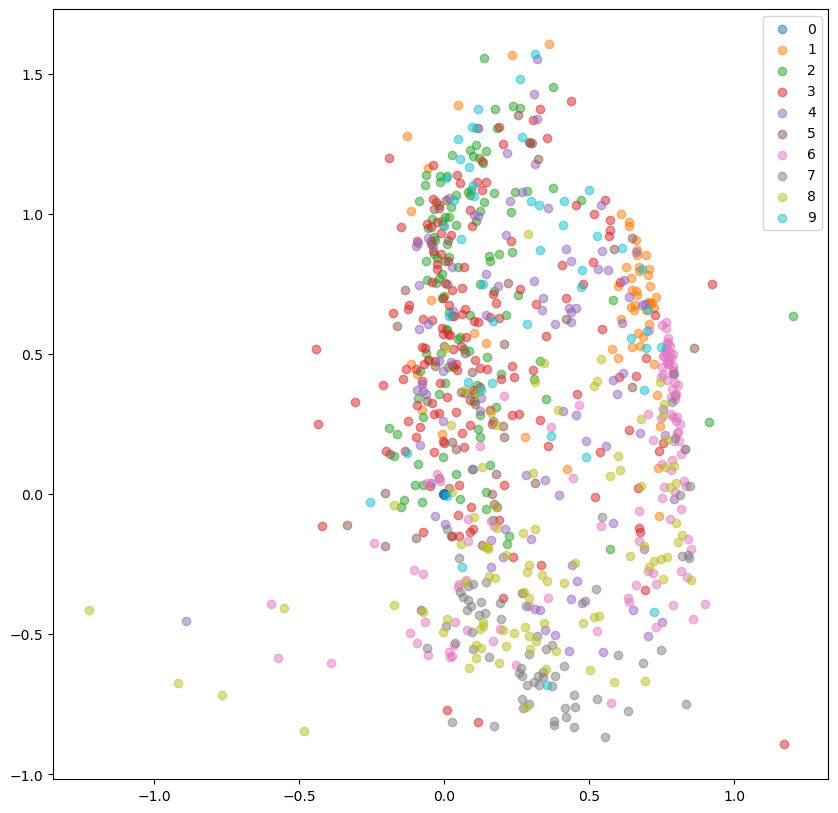

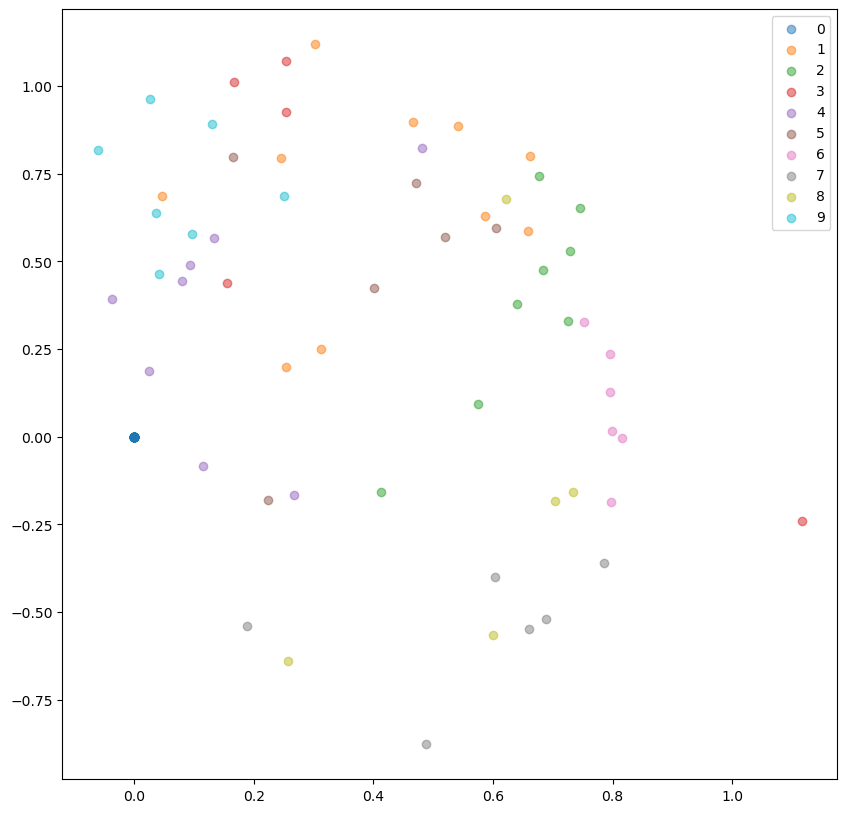

In [21]:
train_subset_unified = VoxCeleb1IdentificationUnified(train_dataset, present_audio_files= present_train_audio_files)
train_loader = torch.utils.data.DataLoader(train_subset_unified, batch_size=batch_size, shuffle=True, drop_last=True, **kwargs) # type: ignore

test_subset_unified = VoxCeleb1IdentificationUnified(test_dataset, present_audio_files= present_test_audio_files)
test_loader = torch.utils.data.DataLoader(test_subset_unified, batch_size=batch_size, shuffle=False, drop_last=True, **kwargs) # type: ignore

train_embeddings_tl, train_labels_tl = extract_embeddings(train_loader, embedding_net)
plot_embeddings(train_embeddings_tl, train_labels_tl)
val_embeddings_tl, val_labels_tl = extract_embeddings(test_loader, embedding_net)
plot_embeddings(val_embeddings_tl, val_labels_tl)